In [252]:
import pandas as pd
import os
import numpy as np

Form a graph with people as nodes with edges between them if they have starred in the same movie. Search for some correlation between how well connected people are and the kind of movies they have performed in / the type of role they have etc.
Once such hypotheses have been formed, test them in a similar graph in the imdb movie dataset to see if they hold there as well. 

Test the hypothesis that an uncommon combination of genres means a somewhat extreme box office collection - either low or high



Is benford's law scale invariant?

## Merging characters and movies

In [253]:
movie_df = pd.read_csv('ADA_venv/data/movie.metadata.tsv', sep='\t', names=['wiki_movie_id', 'freebase_movie_id', 'title', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres'], index_col='freebase_movie_id')
movie_df = movie_df.reset_index()

In [254]:
movie_df['parsed_movie_name'] = movie_df['title'].str.lower().str.strip()

In [255]:
col_names = ["wiki_movie_id", "freebase_movie_id", "movie_release_date", "character_name", "actor_date_of_birth", "Actor gender", "Actor height (in meters)", "Actor ethnicity (Freebase ID)", "Actor name", "Actor age at movie release", "Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"]
character_df = pd.read_csv('ADA_venv/data/character.metadata.tsv', sep='\t', names=col_names, index_col="Freebase character ID")

# Remove characters without actors
character_df = character_df[character_df['Freebase actor ID'].notna()]

# Allow only one character per actor per movie.
# Motivation: When we look at if the actor won a Oscar we don't care about what role it won it as. 
character_df = character_df.groupby(['freebase_movie_id', 'Freebase actor ID']).first().reset_index()

character_df['parsed_actor_name'] = character_df['Actor name'].str.lower().str.strip()

# How many cases where the actors of the same name stars in the same movie or
temp = character_df.groupby(['freebase_movie_id', 'parsed_actor_name']).agg(count = ('parsed_actor_name', 'size')).reset_index()
movies_with_actors_of_same_name_df = temp[temp['count'] > 1]
print('Number of movies with actors of the same name:', movies_with_actors_of_same_name_df.shape[0])

# Only 313 we decide to drop the cases.
# TODO: Check if any of the 311 actors won Oscars
character_df = character_df.merge(temp, on=['freebase_movie_id', 'parsed_actor_name'], how='inner')
dropped_character_df = character_df[character_df['count'] == 1]

temp = dropped_character_df.groupby(['freebase_movie_id', 'parsed_actor_name']).agg(count = ('parsed_actor_name', 'size')).reset_index()

assert temp[temp['count'] > 1].empty

character_df = dropped_character_df

Number of movies with actors of the same name: 313


In [256]:
movie_character_df = movie_df.merge(character_df, on='freebase_movie_id', how='inner')
movie_character_df = movie_character_df[[
    'freebase_movie_id',
    'title',
    'release_date',
    'box_office_revenue',
    'runtime',
    'languages',
    'countries',
    'genres',
    'parsed_movie_name',
    'Freebase actor ID',
    'Actor gender',
    'Actor height (in meters)',
    'Actor ethnicity (Freebase ID)',
    'Actor name',
    'Actor age at movie release',
    'Freebase character/actor map ID',
    'parsed_actor_name'
]]


In [257]:
# To join with Oscar Movie name and Actor name need to uniquely identify one row in movie_character_df 
temp = movie_character_df.groupby(['parsed_movie_name', 'parsed_actor_name']).agg(count = ('parsed_movie_name', 'size')).reset_index()
print('Number of combination of actors of the same names starring in movies with the same name:', temp[temp['count'] > 1].shape[0])

# 350 combination. We decide to drop the combinations 
# TODO: Check if any movie won an Oscar
dropped_movie_character_df = movie_character_df.merge(temp, on=['parsed_movie_name', 'parsed_actor_name'], how='inner')
dropped_movie_character_df = dropped_movie_character_df[dropped_movie_character_df['count'] == 1]

temp = dropped_movie_character_df.groupby(['parsed_movie_name', 'parsed_actor_name']).agg(count = ('parsed_movie_name', 'size'))

assert temp['count'].max() == 1

movie_character_df = dropped_movie_character_df
movie_character_df = movie_character_df.drop('count', axis=1)

Number of combination of actors of the same names starring in movies with the same name: 350


## Merging with oscar dataset

In [258]:
oscar_df = pd.read_csv('ADA_venv/data/the_oscar_award.csv')

# Removes weird Oscar nomination
oscar_df = oscar_df[oscar_df['film'].notna() & oscar_df['name'].notna()]

In [259]:
# Filtering relevant Oscar catagories
# TODO: explain why we drop certain categories.
oscar_df = oscar_df[oscar_df['category'].str.contains('ACTOR') | oscar_df['category'].str.contains('ACTRESS')]

This join needs to be checked. 
Joining with ignore case? 
Do we want to do a right join? (so also keep movies that did not win oscars)


In [260]:
# Avoid case-sensitivity and extra spaces
oscar_df['parsed_movie_name'] = oscar_df['film'].str.lower().str.strip()
oscar_df['parsed_actor_name'] = oscar_df['name'].str.lower().str.strip()

In [261]:
# One actor won two Oscars for the same movie (Barry Fitzgerald)
oscar_df.groupby(['parsed_movie_name', 'parsed_actor_name']).agg(count = ('parsed_actor_name', 'count')).sort_values('count', ascending=False)

# If actor has mutiple nomination for the same movie we choose the first
oscar_df = oscar_df.groupby(['parsed_movie_name', 'parsed_actor_name']).first().reset_index()

# For joining rows in oscar_df needs to be uniquely identified by name_parsed and film_title_parsed
assert oscar_df.groupby(['parsed_movie_name', 'parsed_actor_name']).agg(count = ('parsed_movie_name', 'size')).max()['count'] == 1

In [262]:
movie_character_oscar_df = movie_character_df.merge(oscar_df, how='outer', on=['parsed_movie_name', 'parsed_actor_name'])

In [263]:
# Create column to determine if actor was nominated for Oscar 
movie_character_oscar_df['oscar_nominated'] = movie_character_oscar_df['winner'].notna()

In [264]:
oscar_nominated_actors_df = movie_character_oscar_df[movie_character_oscar_df['oscar_nominated']]
print('Number of different Oscar nominated films in dataset:', 
      oscar_nominated_actors_df['parsed_movie_name'].unique().shape[0])

print('Number of different Oscar nominated actors in dataset:', 
      oscar_nominated_actors_df['parsed_actor_name'].unique().shape[0])

print('Number of characters in dataset:', oscar_nominated_actors_df.shape[0])
print('Number of movies in dataset:', oscar_nominated_actors_df['parsed_movie_name'].unique().shape[0])
print('Number of actors in dataset:', oscar_nominated_actors_df['parsed_actor_name'].unique().shape[0])

Number of different Oscar nominated films in dataset: 1201
Number of different Oscar nominated actors in dataset: 982
Number of characters in dataset: 1827
Number of movies in dataset: 1201
Number of actors in dataset: 982


## Merging with IMDB ratings

In [265]:
#Read data
titlebasics_df = pd.read_csv('ADA_venv/data/title.basics.tsv', sep='\t')
titleratings_df = pd.read_csv('ADA_venv/data/title.ratings.tsv', sep='\t')

/var/folders/0y/ghdjhlvn38sf02nh2qxl20_c0000gn/T/ipykernel_71442/2118823699.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titlebasics_df = pd.read_csv('ADA_venv/data/title.basics.tsv', sep='\t')


In [266]:
titlebasics_df['titleType'].unique()

array(['short', 'movie', 'tvShort', 'tvMovie', 'tvEpisode', 'tvSeries',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame', 'tvPilot'],
      dtype=object)

In [267]:
titleratings_df

,tconst,averageRating,numVotes
0,tt0000001,5.7,2098
1,tt0000002,5.6,282
2,tt0000003,6.5,2117
3,tt0000004,5.4,182
4,tt0000005,6.2,2848
...,...,...,...
1496495,tt9916730,7.0,12
1496496,tt9916766,7.1,24
1496497,tt9916778,7.2,37
1496498,tt9916840,6.9,11


In [268]:
#Merge dataframes containing ratings and title names
name_rating_df = titlebasics_df.merge(titleratings_df, how='inner', on=['tconst', 'tconst'])
#Consider only movies
name_rating_df = name_rating_df[(name_rating_df["titleType"] == 'movie')]
#Get relevant columns
name_rating_df = name_rating_df[["primaryTitle", "startYear", "averageRating", "numVotes"]]

In [269]:
#Change the year data in IMDB dataset to float for merging to work
#\\N is a special value used for missing, replace with NaN so it can't be used for merging
name_rating_df["startYear"] = name_rating_df["startYear"].replace('\\N', np.nan)
name_rating_df["startYear"] = name_rating_df["startYear"].astype(float)
#Rename columns for merge
name_rating_df.rename(columns={'primaryTitle': 'title', 'startYear' : 'year', 'titleType': 'type'}, inplace=True)

In [270]:
#Have to take care of duplicate entries for movies in the same year
#ASSUME they are the same movie and aggregate the scores: sum up the numVotes and calculate the
#new average rating taking into account the number of votes

#The ratings need to be weighted to account for the number of votes
name_rating_df["RatingWeight"] = name_rating_df['averageRating'] * name_rating_df['numVotes']
# Group by title and year for duplicates, sum the number of votes and the weighted ratings
name_rating_agg_df = name_rating_df.groupby(['title','year']).agg(
    numVotes=('numVotes', 'sum'),
    RatingWeight = ('RatingWeight','sum'), 
).reset_index()

#Undo the previous weighing, dividing by number of all votes
name_rating_agg_df['averageRating'] = name_rating_agg_df['RatingWeight'] / name_rating_agg_df['numVotes']
#All ratings have 1 space after comma
name_rating_agg_df['averageRating'] = name_rating_agg_df['averageRating'].round(1)

#Drop the temporary weighted ratings
name_rating_agg_df.drop(columns='RatingWeight', inplace=True)

In [271]:
#Get the year of release of the movies from the mixed formatting
dates_as_year = pd.to_datetime(movie_character_oscar_df["release_date"],format='mixed',errors='coerce').dt.year

#Copy of the dataset with the added year column
movie_character_oscar_fixedDate_df = movie_character_oscar_df.copy(deep=True)
movie_character_oscar_fixedDate_df["year"] = dates_as_year

In [272]:
#Merge ratings with everything previous (left merge because we only want to add the ratings where we can, they
#are not the be-all-end-all
movie_character_oscar_rating_df = movie_character_oscar_fixedDate_df.merge(
    name_rating_agg_df, on=['title', 'year'], how='left')


In [273]:
movie_character_oscar_rating_df.columns
name_rating_agg_df.columns

Index(['title', 'year', 'numVotes', 'averageRating'], dtype='object')

In [274]:
print('Total number of movies with ratings: ',
      movie_character_oscar_rating_df[movie_character_oscar_rating_df['averageRating'].notna()]['parsed_movie_name'].unique().shape[0])

#Get oscar nominated movies
oscar_nominated_actors_with_ratings_df = movie_character_oscar_rating_df[movie_character_oscar_rating_df['oscar_nominated']]
print('Total number of oscar-nominated movies with ratings: ',
      oscar_nominated_actors_with_ratings_df[oscar_nominated_actors_with_ratings_df['averageRating'].notna()]['parsed_movie_name'].unique().shape[0])

Total number of movies with ratings:  32935
Total number of oscar-nominated movies with ratings:  969


In [275]:
# Assert that adding ratings did not add any rows
assert len(movie_character_oscar_df) == len(movie_character_oscar_rating_df)

## Output data

In [276]:
movie_character_oscar_rating_df[:1]

,freebase_movie_id,title,release_date,box_office_revenue,runtime,languages,countries,genres,parsed_movie_name,Freebase actor ID,...,year_ceremony,ceremony,category,name,film,winner,oscar_nominated,year,numVotes,averageRating
0,/m/0crs0hx,#1 Cheerleader Camp,2010,NaN,90.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01z02hx"": ""Sports"", ""/m/0gsy3b"": ""Sex com...",#1 cheerleader camp,/m/0gm2g0t,...,NaN,NaN,NaN,NaN,NaN,NaN,False,2010.0,NaN,NaN


In [277]:
# Finish processed data
path = 'cache/processed data.csv'
os.makedirs('cache', exist_ok=True)
movie_character_oscar_rating_df.to_csv(path)

In [278]:
import matplotlib.pyplot as plt
import seaborn as sns
main_movie_df = movie_character_oscar_rating_df.groupby('title').first().reset_index()
main_with_rating_df = main_movie_df[main_movie_df['averageRating'].notna()]

In [288]:
nominated = main_with_rating_df[main_with_rating_df['oscar_nominated']]
not_nominated = main_with_rating_df[main_with_rating_df['oscar_nominated'] == False]
assert nominated.shape[0] + not_nominated.shape[0] == main_with_rating_df.shape[0]

In [ ]:
# Rule of thumb to exlude outliers / low confidence values 
excluded = not_nominated[not_nominated['numVotes'] < 30]
print('Excluded: ', len(excluded))
not_nominated = not_nominated[not_nominated['numVotes'] > 30]
nominated = nominated[nominated['numVotes'] > 30]

Excluded:  2062


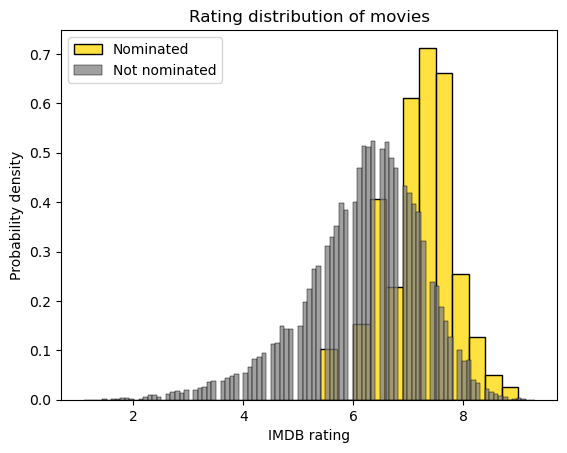

In [290]:
sns.histplot(nominated, x="averageRating", stat = 'density', color = 'gold',label ='Nominated')
sns.histplot(not_nominated, x="averageRating", stat="density", color = 'grey', label = 'Not nominated')

plt.title('Rating distribution of movies')
plt.xlabel('IMDB rating')
plt.ylabel('Probability density')
plt.legend()
plt.show()


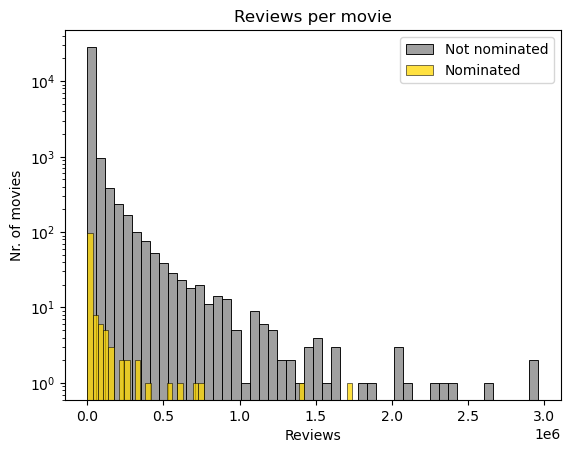

In [ ]:
sns.histplot(not_nominated, x="numVotes", bins=50, label = 'Not nominated', color = 'grey')
sns.histplot(nominated, x="numVotes", bins=50, label = 'Nominated', color = 'gold')
plt.yscale('log')
plt.title('Reviews per movie')
plt.xlabel('Reviews')
plt.ylabel('Nr. of movies')
plt.legend()
plt.show()

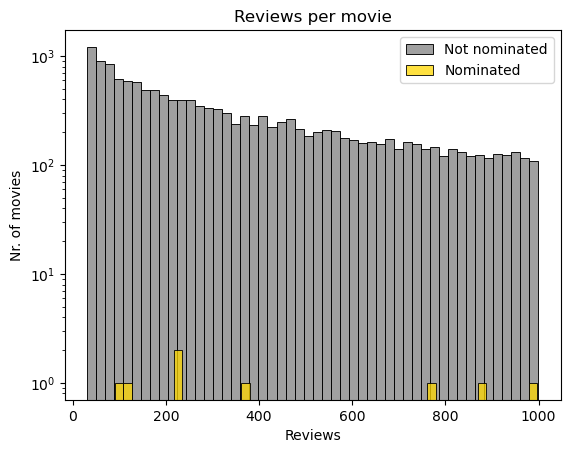

In [296]:
lim_not_nominated = not_nominated[not_nominated['numVotes'] < 1000]
lim_nominated = nominated[nominated['numVotes'] < 1000]

sns.histplot(lim_not_nominated, x="numVotes", bins=50, label = 'Not nominated', color = 'grey')
sns.histplot(lim_nominated, x="numVotes", bins=50, label = 'Nominated', color = 'gold')
plt.yscale('log')
plt.title('Reviews per movie')
plt.xlabel('Reviews')
plt.ylabel('Nr. of movies')
plt.legend()
plt.show()

Index(['title', 'freebase_movie_id', 'release_date', 'box_office_revenue',
       'runtime', 'languages', 'countries', 'genres', 'parsed_movie_name',
       'Freebase actor ID', 'Actor gender', 'Actor height (in meters)',
       'Actor ethnicity (Freebase ID)', 'Actor name',
       'Actor age at movie release', 'Freebase character/actor map ID',
       'parsed_actor_name', 'year_film', 'year_ceremony', 'ceremony',
       'category', 'name', 'film', 'winner', 'oscar_nominated', 'year',
       'numVotes', 'averageRating'],
      dtype='object')

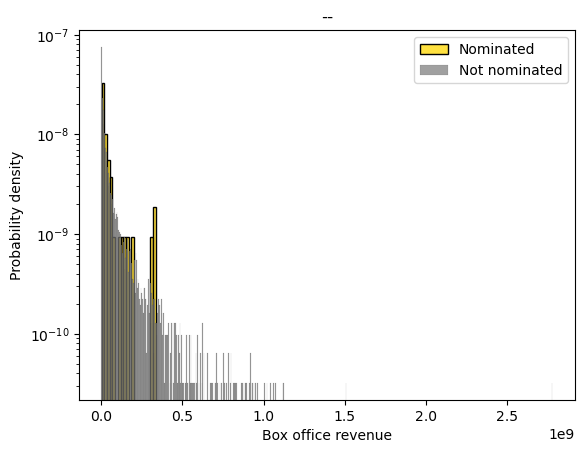

In [300]:
sns.histplot(nominated, x="box_office_revenue", stat = 'density', color = 'gold',label ='Nominated')
sns.histplot(not_nominated, x="box_office_revenue", stat="density", color = 'grey', label = 'Not nominated')

plt.title('--')
plt.yscale('log')
plt.xlabel('Box office revenue')
plt.ylabel('Probability density')
plt.legend()
plt.show()

In [ ]:
lim_not_nominated = not_nominated[not_nominated['numVotes'] < 10**9]
lim_nominated = nominated[nominated['numVotes'] < 10**9]